# EEG Data Exploration

This notebook explores the raw EEG data characteristics and distributions.

In [3]:
import sys
sys.path.append('../..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import scipy.io
import scipy.signal as signal
from src.utils.config import load_config


## 1. Load Data

In [6]:
# Load configuration
config = load_config('../../configs/processing_config.yaml')

# Load raw data
mat_data = scipy.io.loadmat(config['paths']['raw_data'])
print("Available data keys:", mat_data.keys())

🔍 DEBUG: Loading config from: ../../configs/processing_config.yaml
🔍 DEBUG: Config loaded successfully from ../../configs/processing_config.yaml
{"timestamp": "2025-11-25T18:12:46.840554", "level": "INFO", "name": "src.utils.config", "module": "config", "funcName": "log_config", "message": "Loaded configuration", "config": "{\"paths\": {\"raw_data\": \"/home/abin/eeg-mlflow/eeg_analysis/data/raw/MDD_21_subjects_EC_EEG_data_remission_and_non_remission_seperated.mat\", \"interim\": {\"upsampled\": \"/home/abin/eeg-mlflow/eeg_analysis/data/processed/interim/upsampled\", \"filtered\": \"/home/abin/eeg-mlflow/eeg_analysis/data/processed/interim/filtered\", \"downsampled\": \"/home/abin/eeg-mlflow/eeg_analysis/data/processed/interim/downsampled\", \"windowed\": \"/home/abin/eeg-mlflow/eeg_analysis/data/processed/interim/windowed\", \"dc_removed\": \"/home/abin/eeg-mlflow/eeg_analysis/data/processed/interim/dc_removed\"}, \"features\": {\"window\": \"/home/abin/eeg-mlflow/eeg_analysis/data/pr

## 2. Data Structure Analysis


Analyzing Remission data:
Number of participants: 10
Windows per participant:
  Mean: 39.3
  Min: 29
  Max: 61

Analyzing Non-remission data:
Number of participants: 19
Windows per participant:
  Mean: 42.6
  Min: 28
  Max: 62


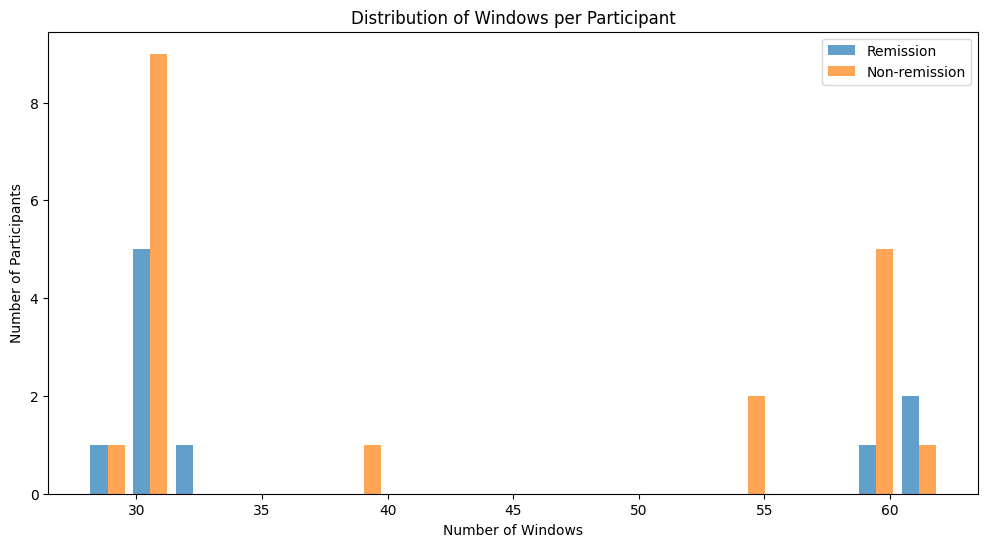

In [7]:
def analyze_group_data(data, group_name):
    """Analyze data structure for a group."""
    print(f"\nAnalyzing {group_name} data:")
    print(f"Number of participants: {data.shape[0]}")
    
    # Analyze windows per participant
    windows_per_participant = [data[i,0].shape[1] for i in range(data.shape[0])]
    print(f"Windows per participant:")
    print(f"  Mean: {np.mean(windows_per_participant):.1f}")
    print(f"  Min: {np.min(windows_per_participant)}")
    print(f"  Max: {np.max(windows_per_participant)}")
    
    return pd.Series(windows_per_participant)

# Analyze both groups
remission_windows = analyze_group_data(mat_data['EEG_windows_Remission'], 'Remission')
non_remission_windows = analyze_group_data(mat_data['EEG_windows_Non_remission'], 'Non-remission')

# Plot window distribution
plt.figure(figsize=(12, 6))
plt.hist([remission_windows, non_remission_windows], label=['Remission', 'Non-remission'],
         alpha=0.7, bins=20)
plt.xlabel('Number of Windows')
plt.ylabel('Number of Participants')
plt.title('Distribution of Windows per Participant')
plt.legend()
plt.show()

## 3. Signal Characteristics

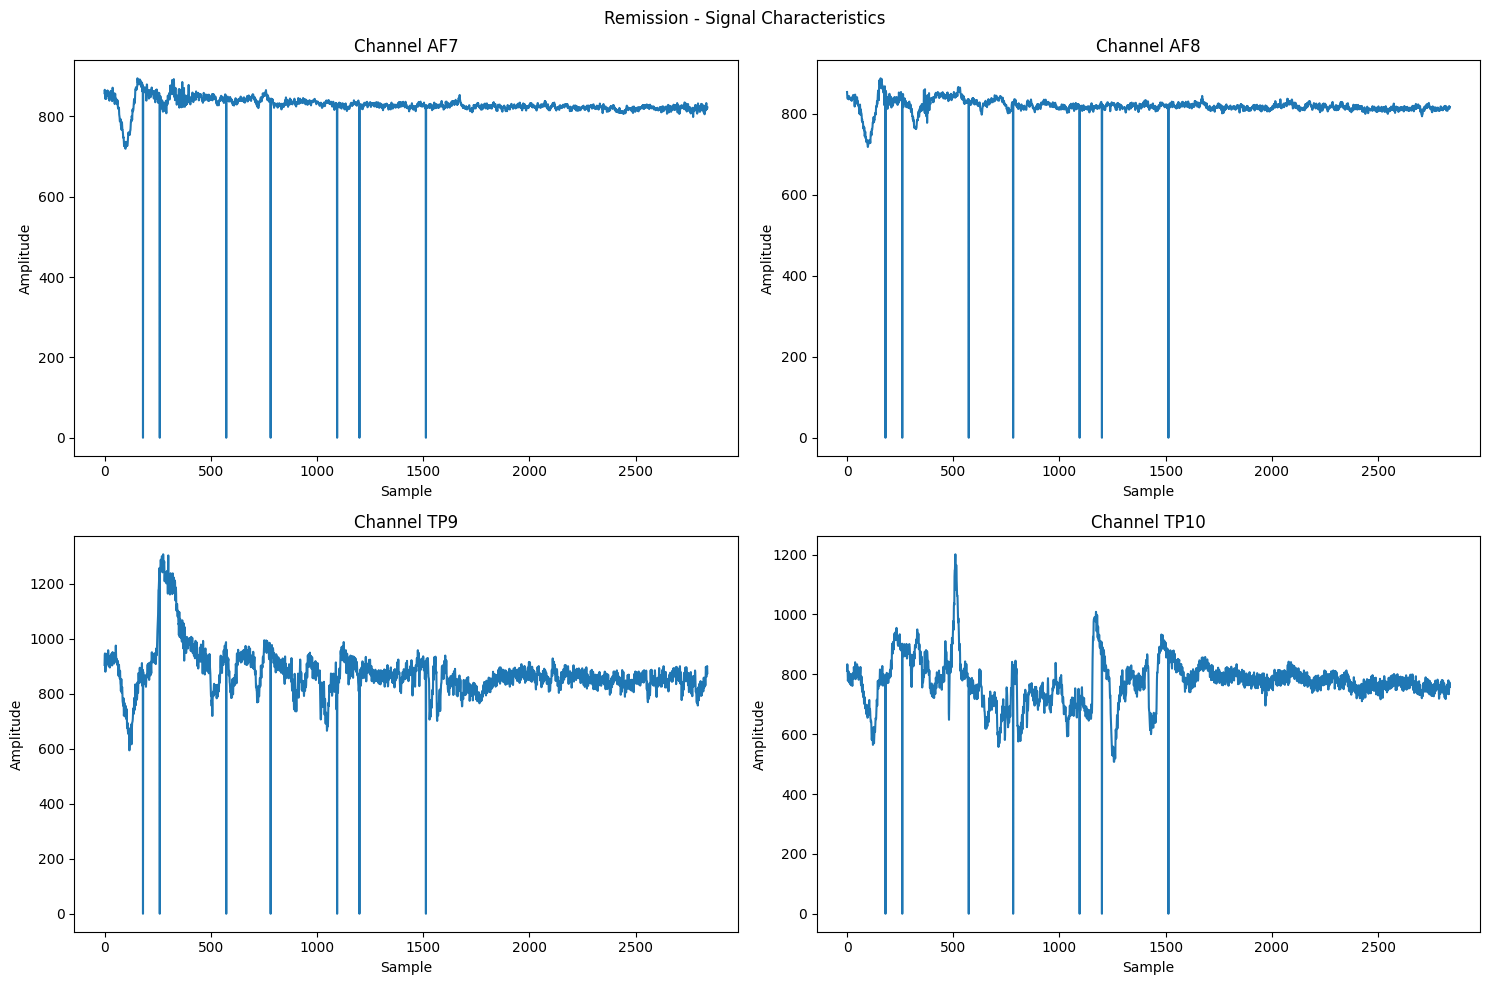

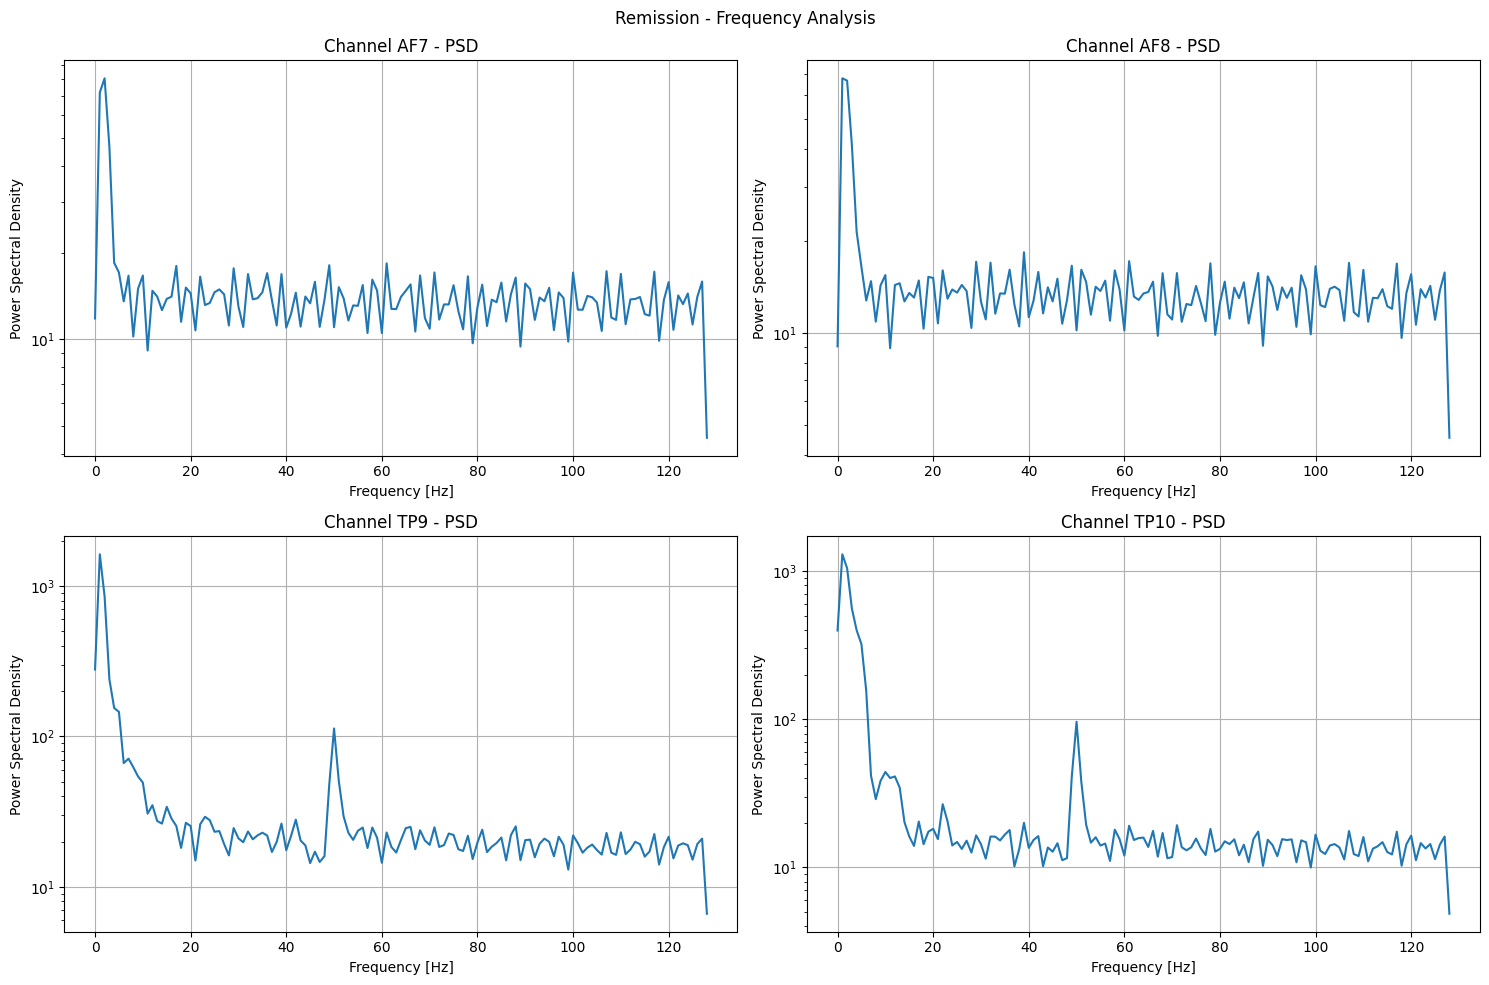

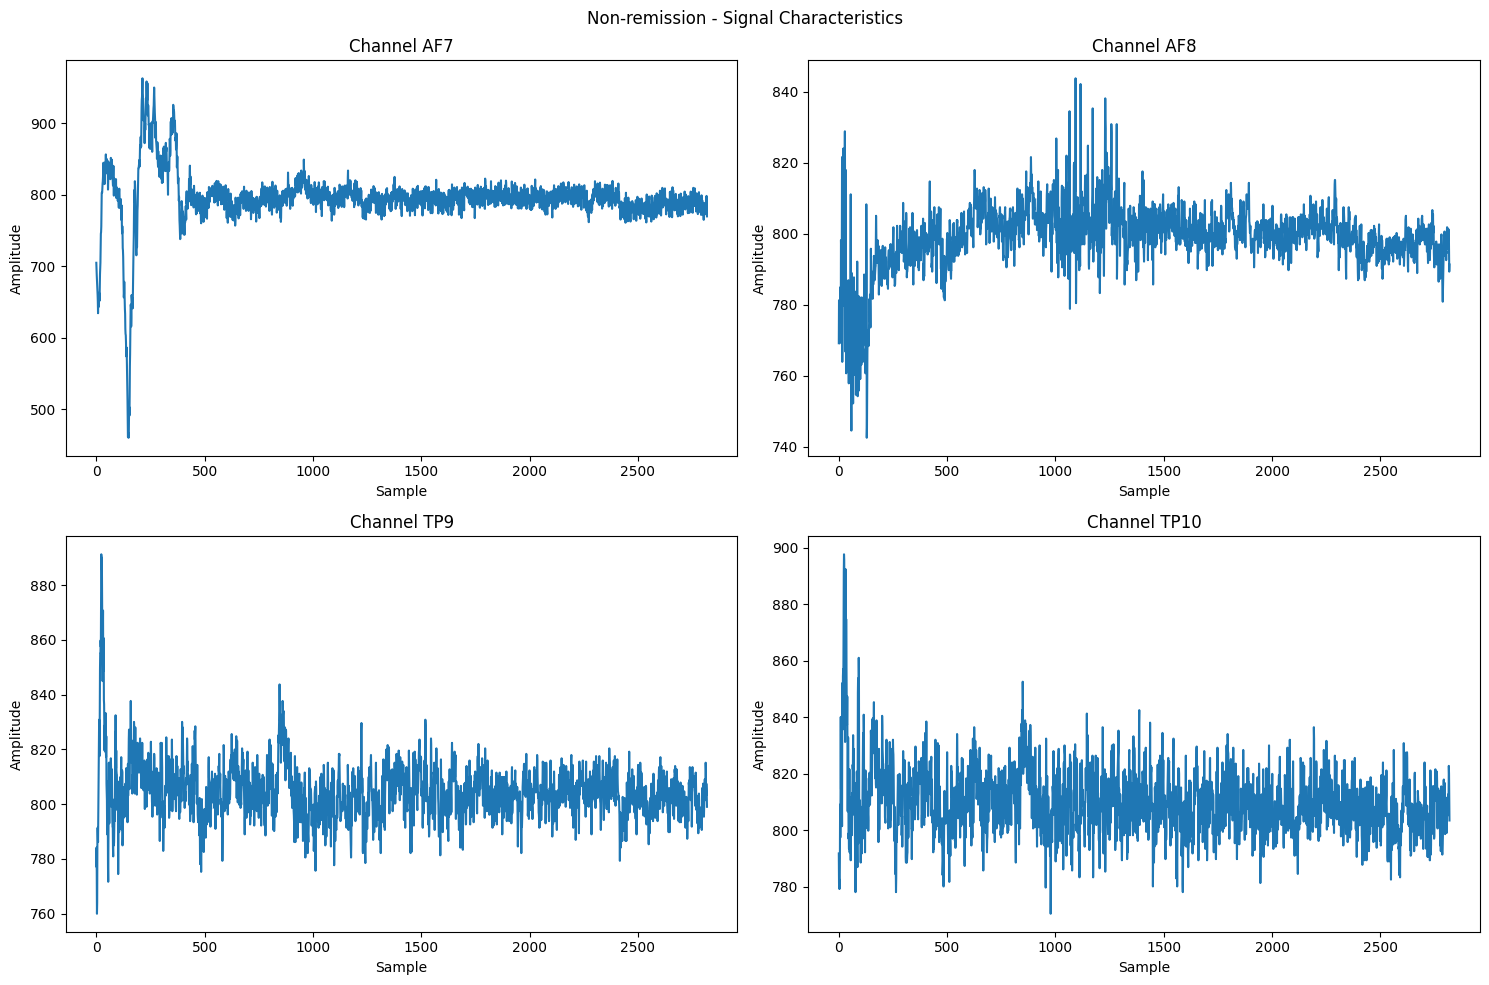

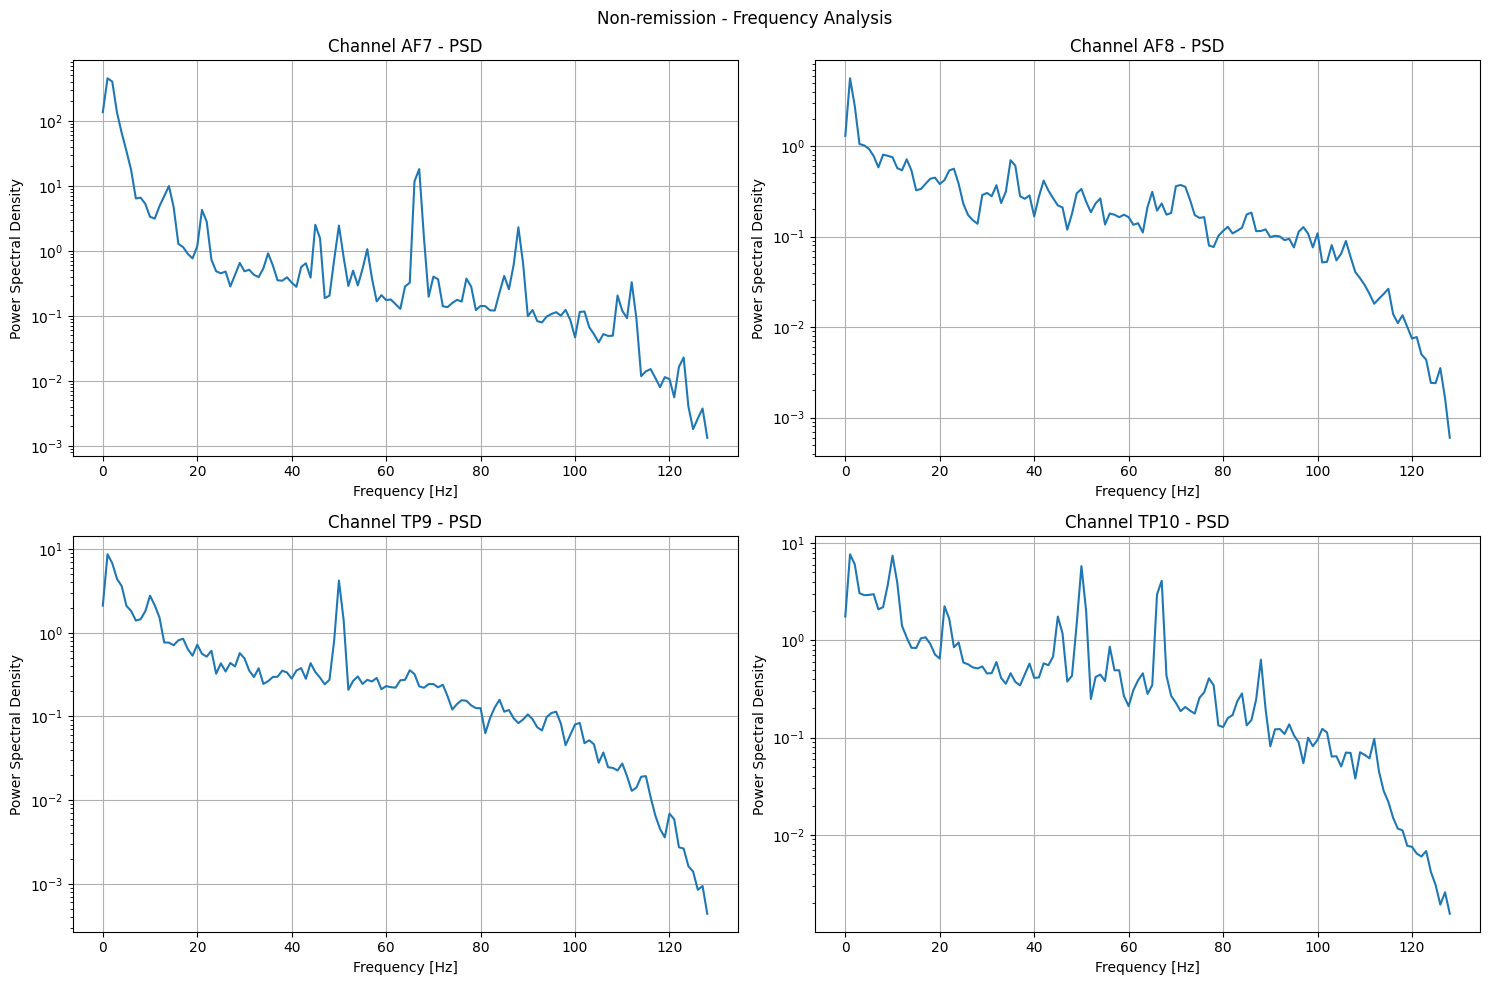

In [8]:
def plot_signal_characteristics(data, group_name):
    """Plot signal characteristics for first window of first participant."""
    signal_data = data[0,0][0,0]
    channels = ['AF7', 'AF8', 'TP9', 'TP10']
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{group_name} - Signal Characteristics')
    
    for idx, (ax, channel) in enumerate(zip(axes.flat, channels)):
        # Time domain plot
        ax.plot(signal_data[:, idx])
        ax.set_title(f'Channel {channel}')
        ax.set_xlabel('Sample')
        ax.set_ylabel('Amplitude')
    
    plt.tight_layout()
    plt.show()
    
    # Frequency domain analysis
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{group_name} - Frequency Analysis')
    
    for idx, (ax, channel) in enumerate(zip(axes.flat, channels)):
        f, Pxx = signal.welch(signal_data[:, idx], fs=config['window_slicer']['sampling_rate'])
        ax.semilogy(f, Pxx)
        ax.set_title(f'Channel {channel} - PSD')
        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('Power Spectral Density')
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot characteristics for both groups
plot_signal_characteristics(mat_data['EEG_windows_Remission'], 'Remission')
plot_signal_characteristics(mat_data['EEG_windows_Non_remission'], 'Non-remission')

## 4. Channel Correlations

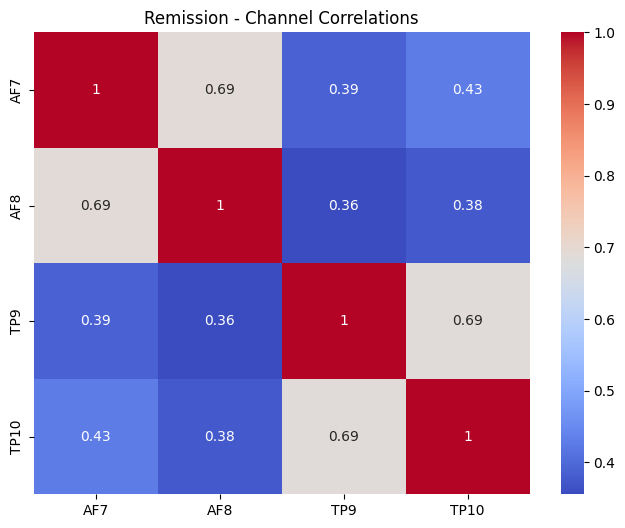

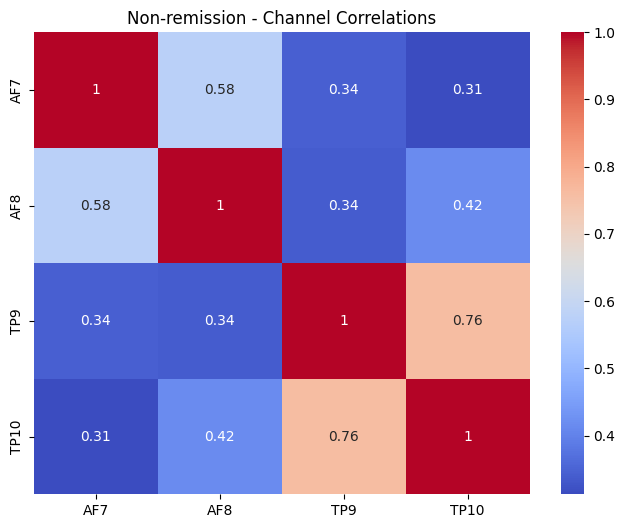

In [9]:
def analyze_channel_correlations(data, group_name):
    """Analyze correlations between channels."""
    channels = ['AF7', 'AF8', 'TP9', 'TP10']
    correlations = []
    
    # Calculate correlations for first window of each participant
    for i in range(data.shape[0]):
        signal_data = data[i,0][0,0]
        corr_matrix = np.corrcoef(signal_data.T)
        correlations.append(corr_matrix)
    
    # Average correlation matrix
    avg_correlation = np.mean(correlations, axis=0)
    
    # Plot correlation heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(avg_correlation, annot=True, cmap='coolwarm', 
                xticklabels=channels, yticklabels=channels)
    plt.title(f'{group_name} - Channel Correlations')
    plt.show()

# Analyze correlations for both groups
analyze_channel_correlations(mat_data['EEG_windows_Remission'], 'Remission')
analyze_channel_correlations(mat_data['EEG_windows_Non_remission'], 'Non-remission')

## 5. Frequency Band Analysis

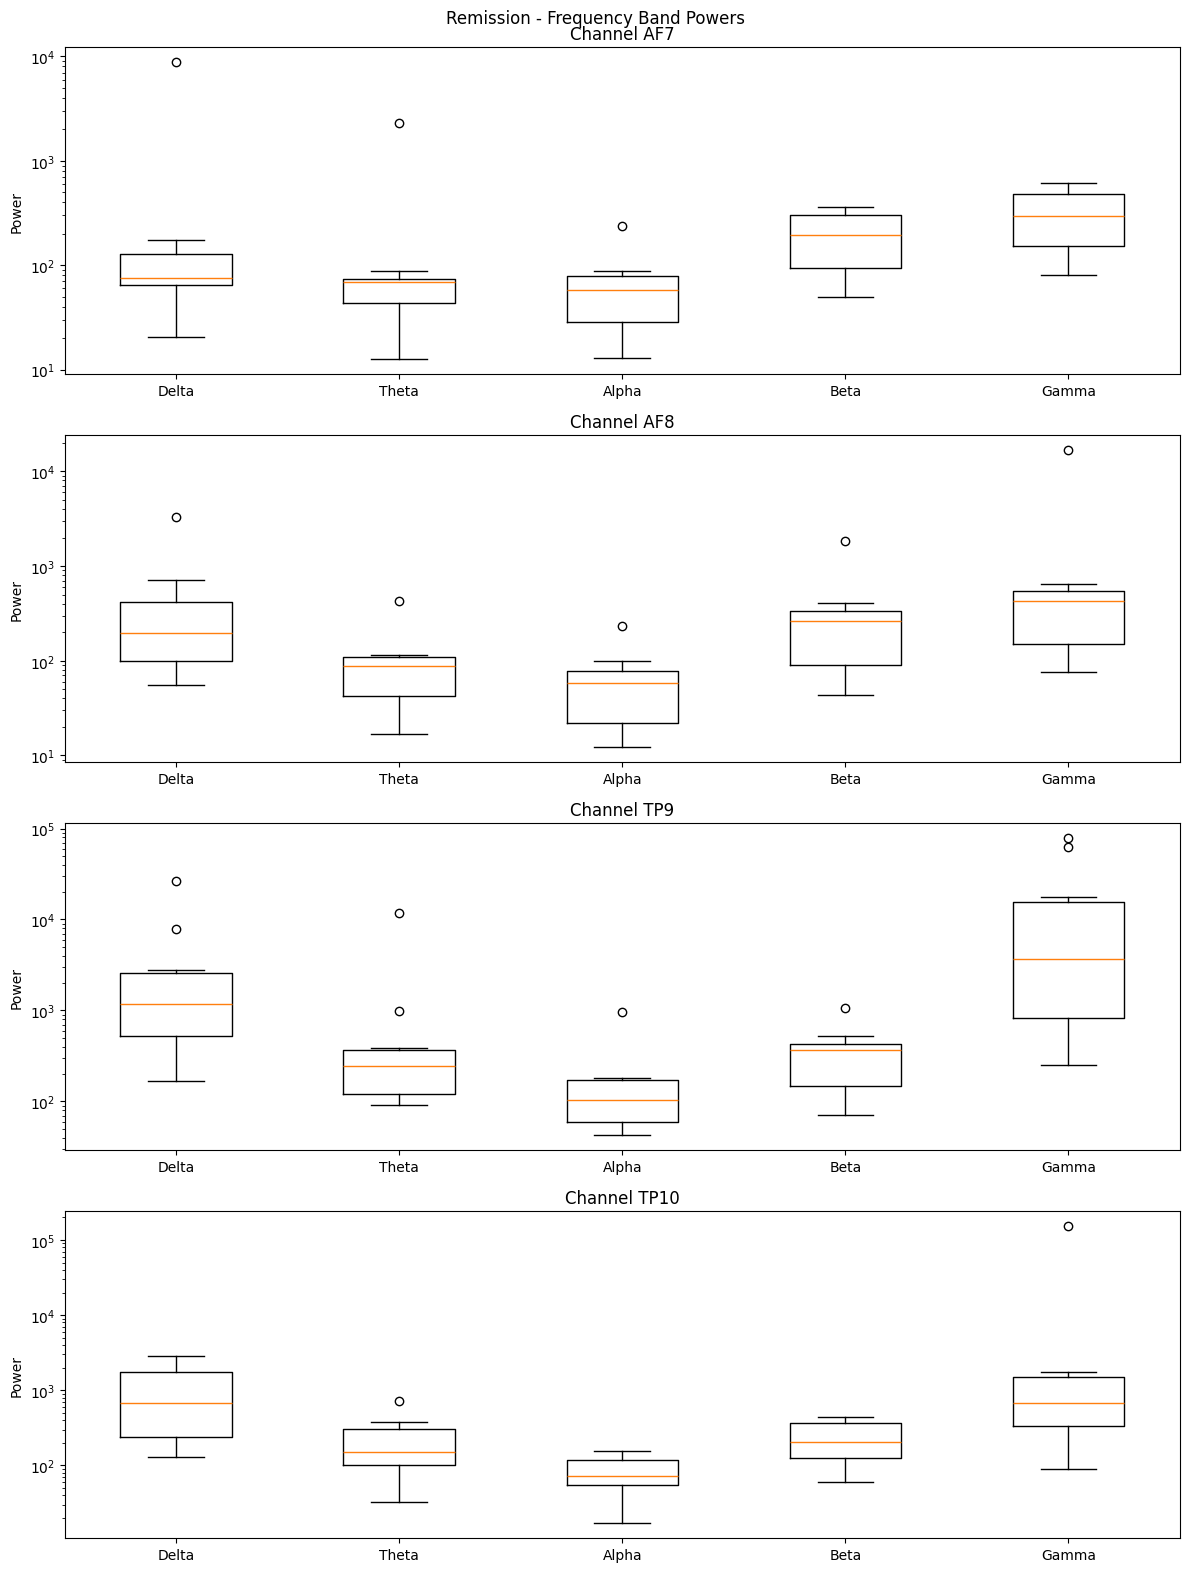

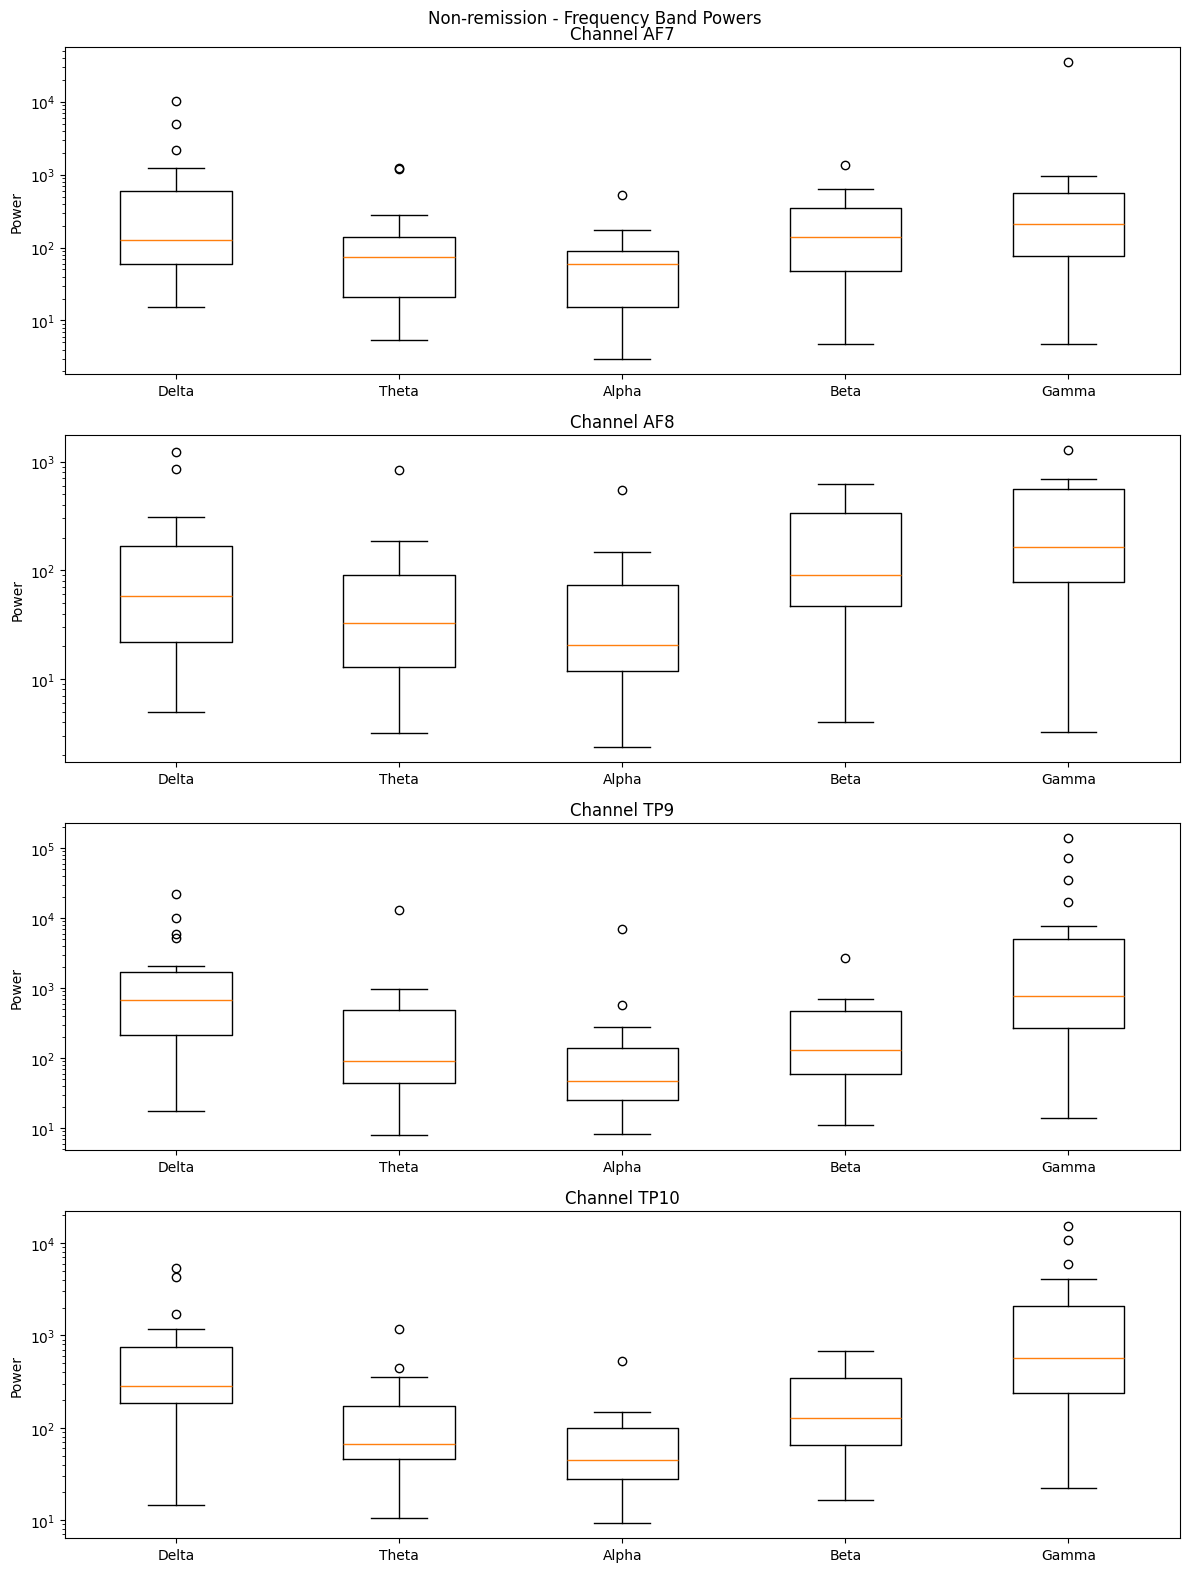

In [10]:
def calculate_band_power(signal_data, fs, band):
    """Calculate power in specific frequency band."""
    f, Pxx = signal.welch(signal_data, fs=fs)
    idx_band = np.logical_and(f >= band[0], f <= band[1])
    return np.trapezoid(Pxx[idx_band], f[idx_band])

def analyze_frequency_bands(data, group_name):
    """Analyze power in different frequency bands."""
    bands = {
        'Delta': (0.5, 4),
        'Theta': (4, 8),
        'Alpha': (8, 12),
        'Beta': (12, 30),
        'Gamma': (30, 60)
    }
    
    channels = ['AF7', 'AF8', 'TP9', 'TP10']
    band_powers = {band: {ch: [] for ch in channels} for band in bands}
    
    # Calculate band powers for first window of each participant
    for i in range(data.shape[0]):
        signal_data = data[i,0][0,0]
        
        for ch_idx, channel in enumerate(channels):
            for band_name, band_range in bands.items():
                power = calculate_band_power(signal_data[:, ch_idx], 
                                           config['window_slicer']['sampling_rate'], 
                                           band_range)
                band_powers[band_name][channel].append(power)
    
    # Plot band powers
    fig, axes = plt.subplots(len(channels), 1, figsize=(12, 4*len(channels)))
    fig.suptitle(f'{group_name} - Frequency Band Powers')
    
    for idx, (ax, channel) in enumerate(zip(axes, channels)):
        data_to_plot = [band_powers[band][channel] for band in bands]
        ax.boxplot(data_to_plot, tick_labels=list(bands.keys()))
        ax.set_title(f'Channel {channel}')
        ax.set_ylabel('Power')
        ax.set_yscale('log')
    
    plt.tight_layout()
    plt.show()

# Analyze frequency bands for both groups
analyze_frequency_bands(mat_data['EEG_windows_Remission'], 'Remission')
analyze_frequency_bands(mat_data['EEG_windows_Non_remission'], 'Non-remission')

## 6. Statistical Analysis

Statistical Analysis Results:

Channel Statistics:
Channel  statistic  p_value
    AF7       98.0 0.908677
    AF8       51.0 0.045943
    TP9      102.0 0.765520
   TP10      102.0 0.765520


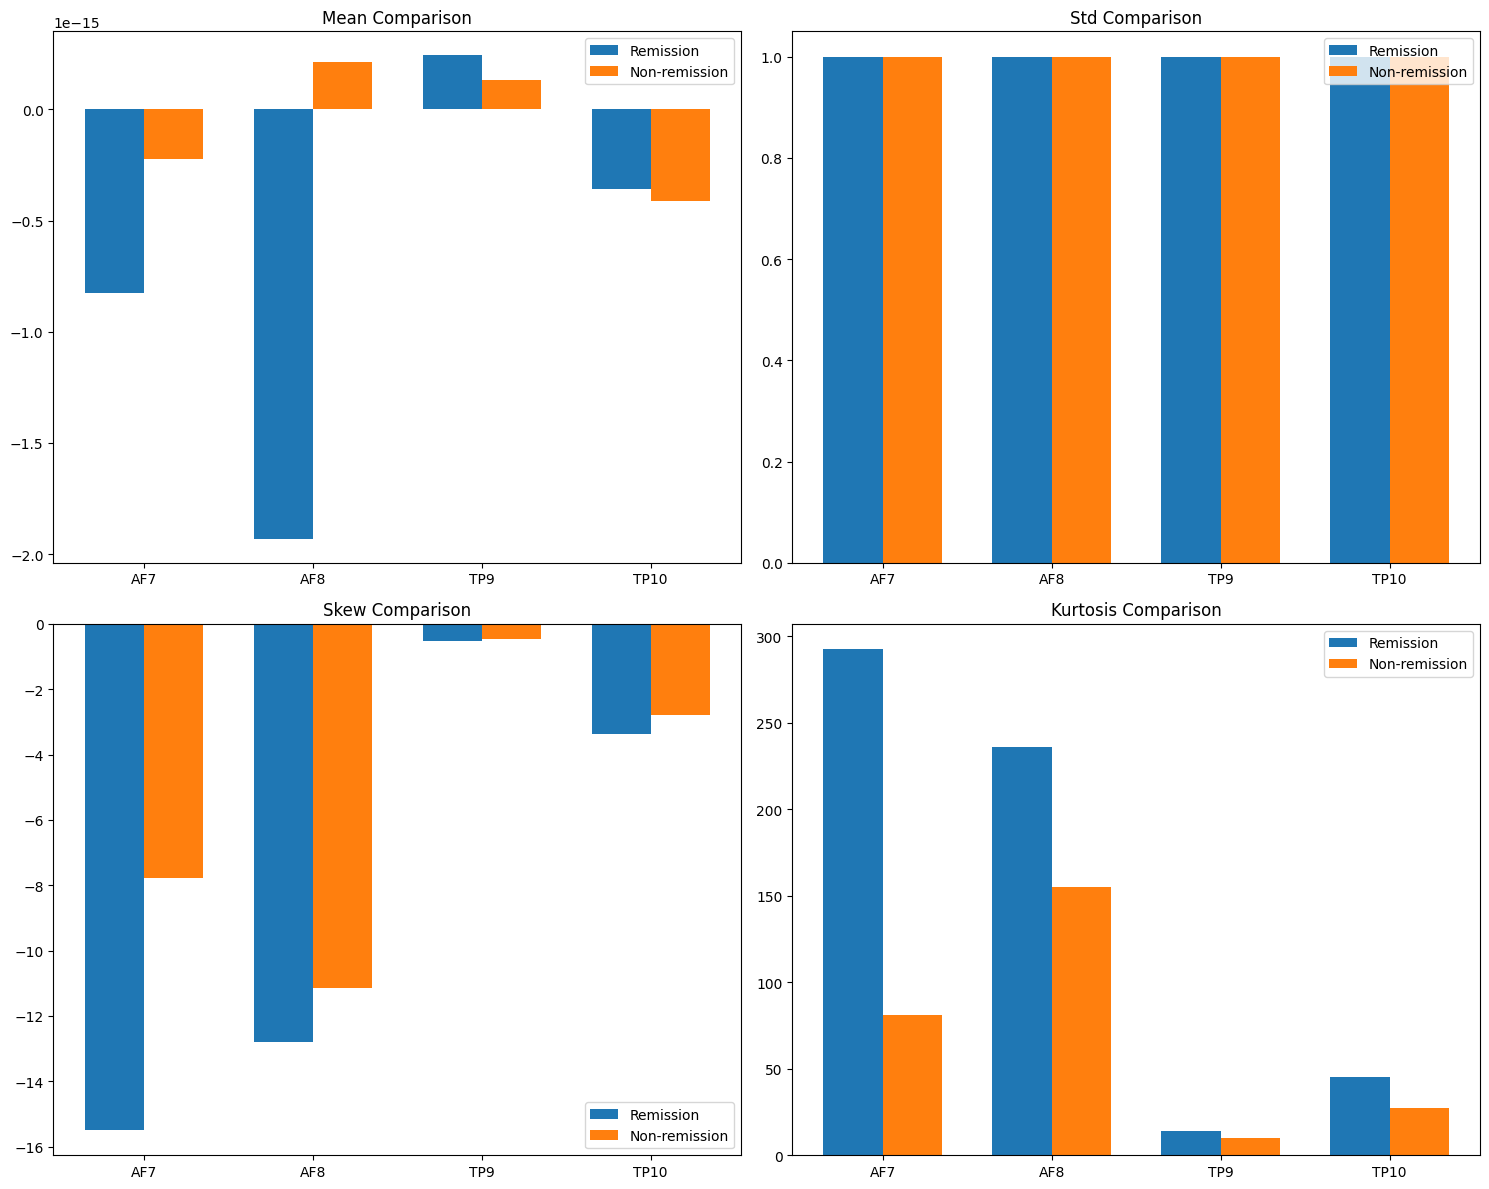

In [11]:
def perform_statistical_analysis(remission_data, non_remission_data):
    """Perform statistical analysis comparing groups."""
    from scipy import stats
    channels = ['AF7', 'AF8', 'TP9', 'TP10']
    
    # Calculate statistics for first window of each participant
    stats_results = []
    
    for ch_idx, channel in enumerate(channels):
        # Extract and normalize channel data
        rem_data = [stats.zscore(remission_data[i,0][0,0][:, ch_idx]) 
                   for i in range(remission_data.shape[0])]
        non_rem_data = [stats.zscore(non_remission_data[i,0][0,0][:, ch_idx]) 
                       for i in range(non_remission_data.shape[0])]
        
        # Calculate basic statistics using median instead of mean for robustness
        rem_stats = {
            'mean': np.median([np.mean(d) for d in rem_data]),
            'std': np.median([np.std(d) for d in rem_data]),
            'skew': np.median([stats.skew(d) for d in rem_data]),
            'kurtosis': np.median([stats.kurtosis(d) for d in rem_data])
        }
        
        non_rem_stats = {
            'mean': np.median([np.mean(d) for d in non_rem_data]),
            'std': np.median([np.std(d) for d in non_rem_data]),
            'skew': np.median([stats.skew(d) for d in non_rem_data]),
            'kurtosis': np.median([stats.kurtosis(d) for d in non_rem_data])
        }
        
        # Use Mann-Whitney U test instead of t-test for more robustness
        mw_result = stats.mannwhitneyu(
            [np.mean(d) for d in rem_data],
            [np.mean(d) for d in non_rem_data],
            alternative='two-sided'
        )
        
        stats_results.append({
            'Channel': channel,
            'Remission': rem_stats,
            'Non-remission': non_rem_stats,
            'statistic': mw_result.statistic,
            'p_value': mw_result.pvalue
        })
        
    # Create results DataFrame
    stats_df = pd.DataFrame(stats_results)
    
    # Display results
    print("Statistical Analysis Results:")
    print("\nChannel Statistics:")
    print(stats_df[['Channel', 'statistic', 'p_value']].to_string(index=False))
    
    # Plot comparative statistics
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    metrics = ['mean', 'std', 'skew', 'kurtosis']
    
    for idx, (metric, ax) in enumerate(zip(metrics, axes.flat)):
        rem_values = [res['Remission'][metric] for res in stats_results]
        non_rem_values = [res['Non-remission'][metric] for res in stats_results]
        
        x = np.arange(len(channels))
        width = 0.35
        
        ax.bar(x - width/2, rem_values, width, label='Remission')
        ax.bar(x + width/2, non_rem_values, width, label='Non-remission')
        
        ax.set_title(f'{metric.capitalize()} Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(channels)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

perform_statistical_analysis(mat_data['EEG_windows_Remission'], 
                            mat_data['EEG_windows_Non_remission'])

Applying DC removal with method: mean


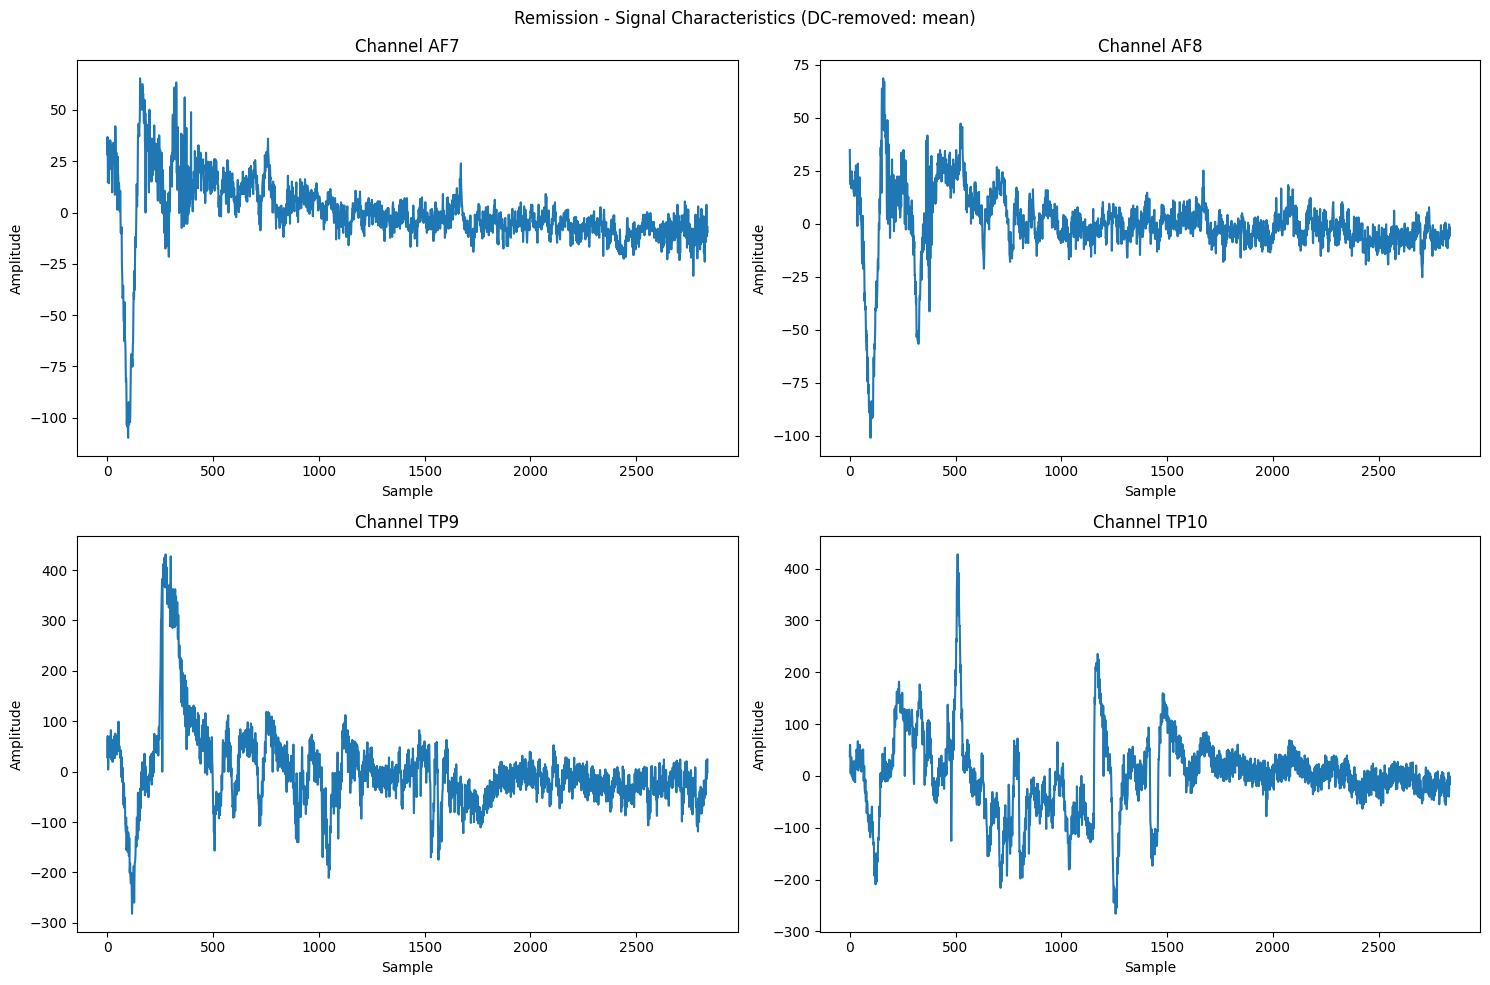

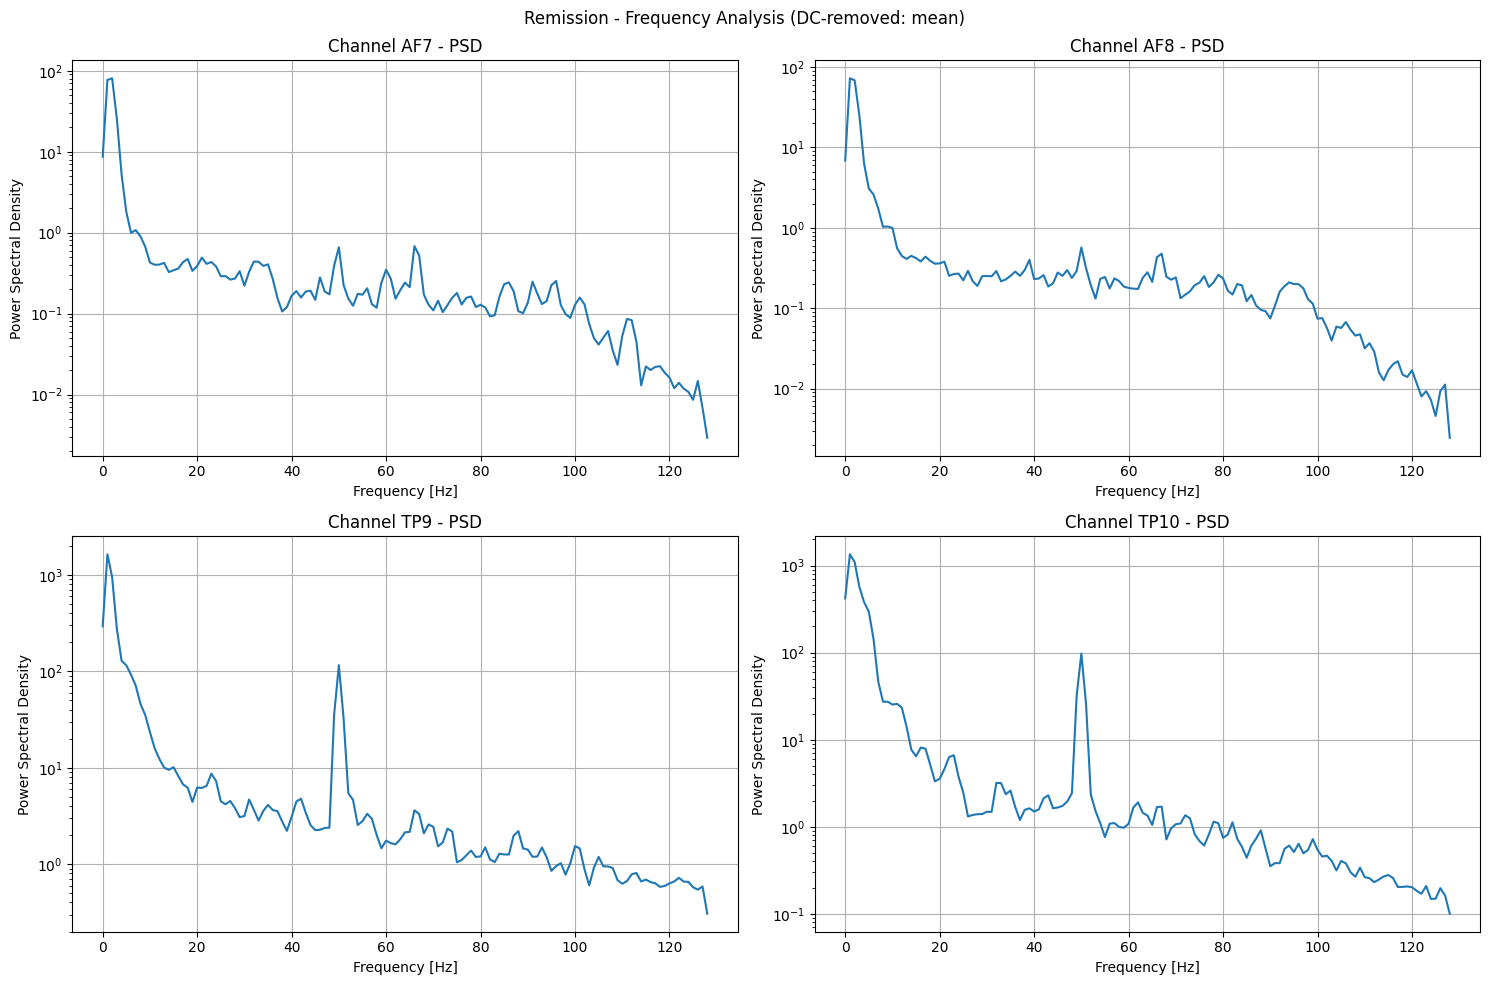

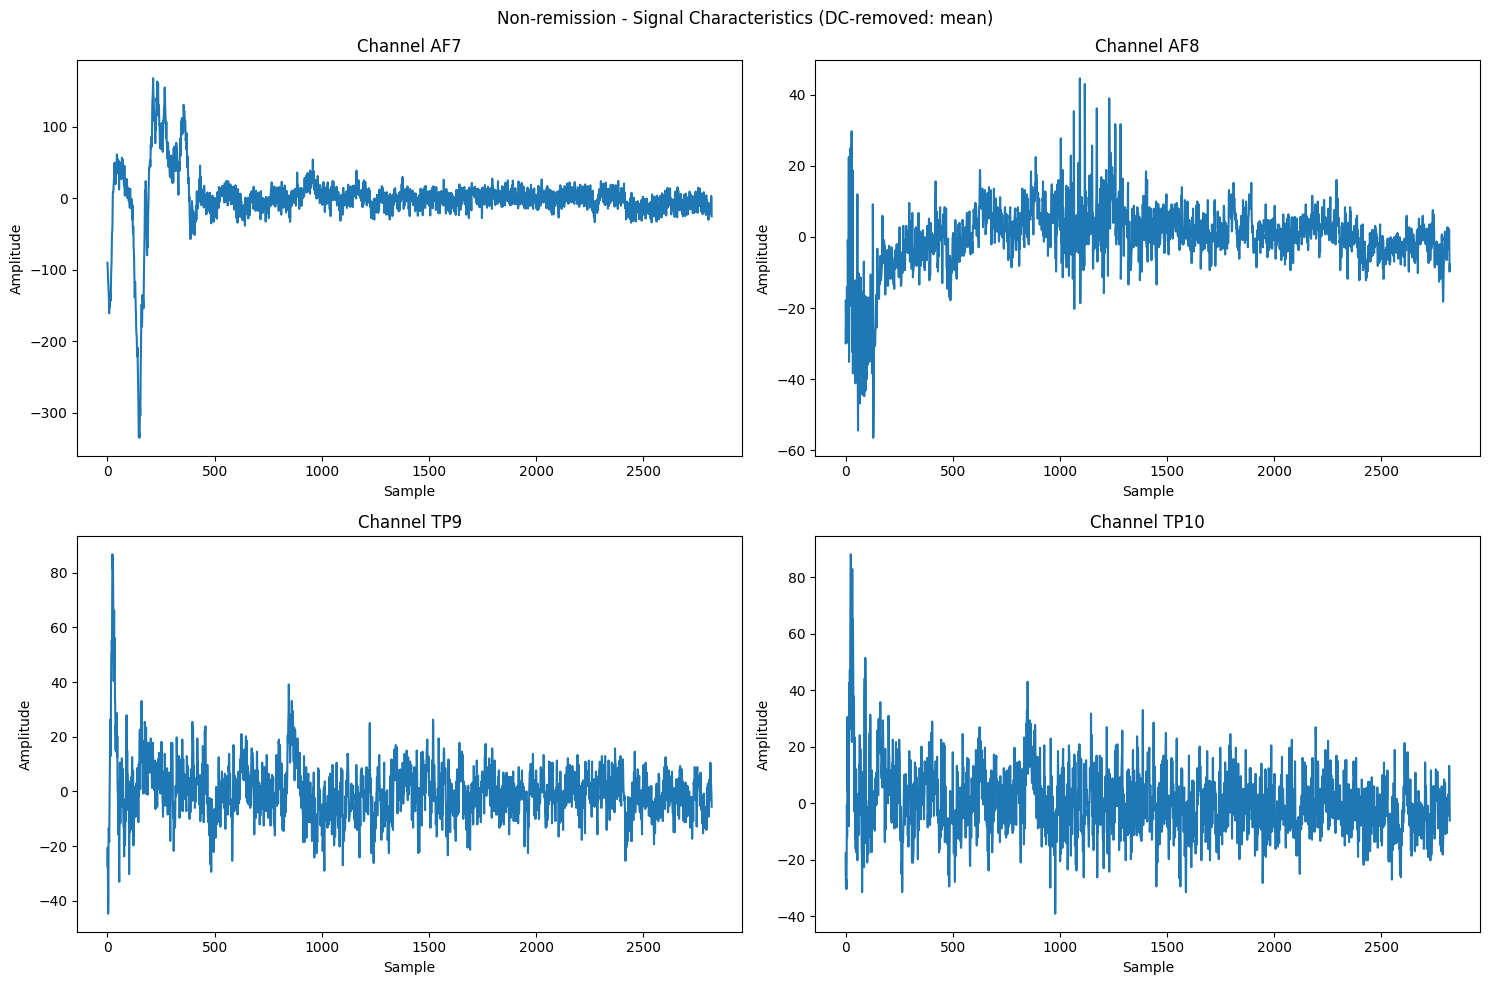

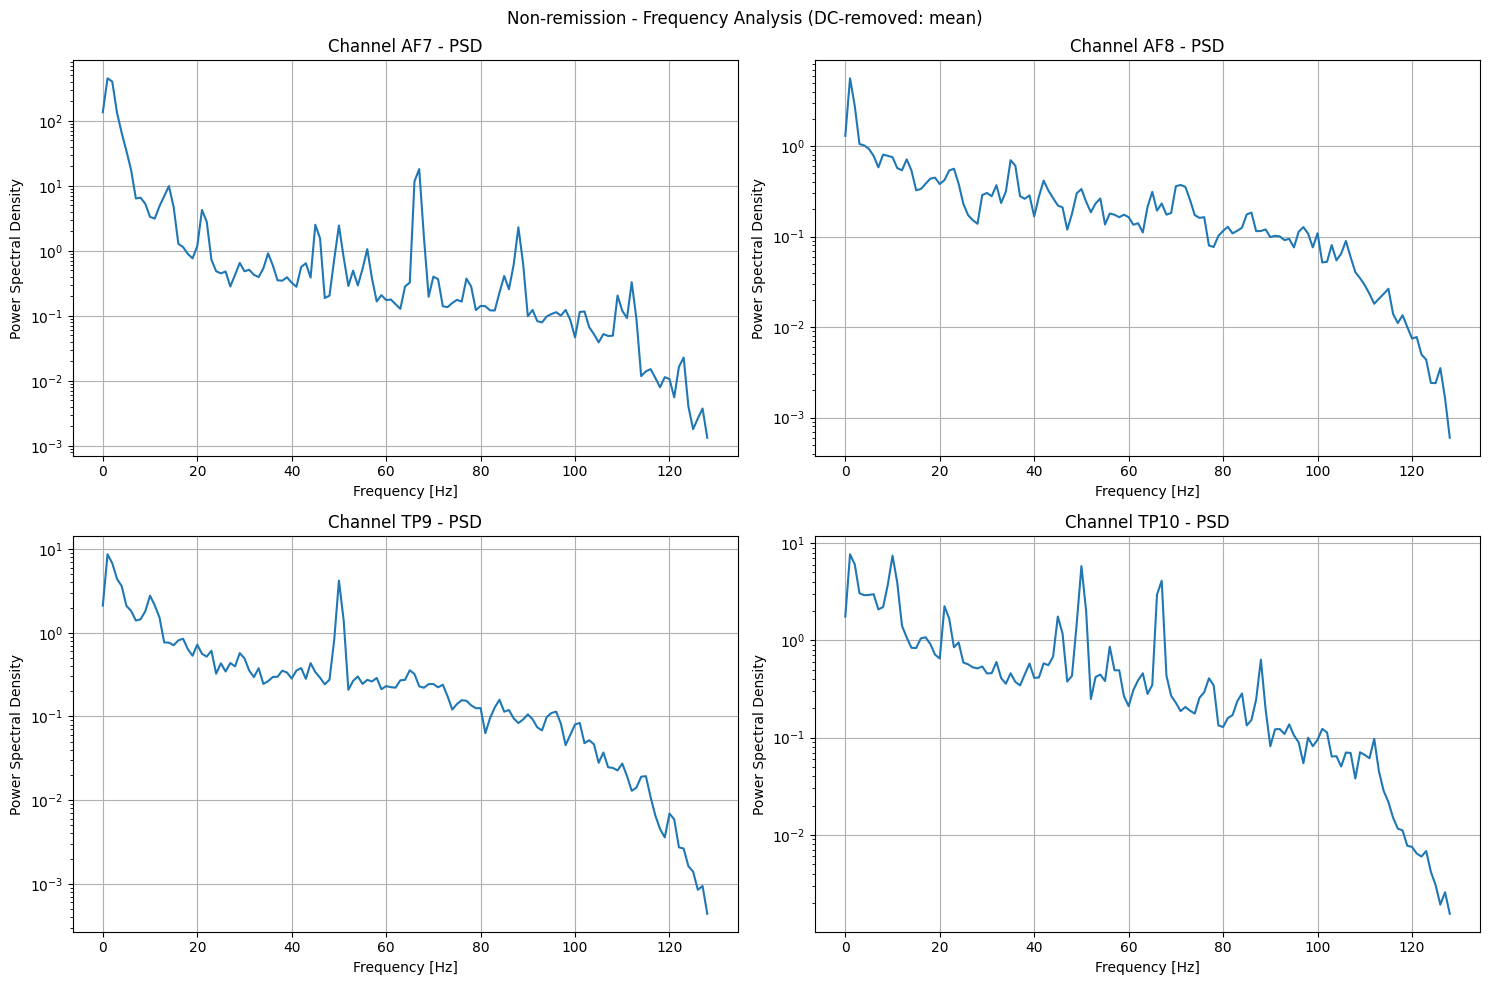

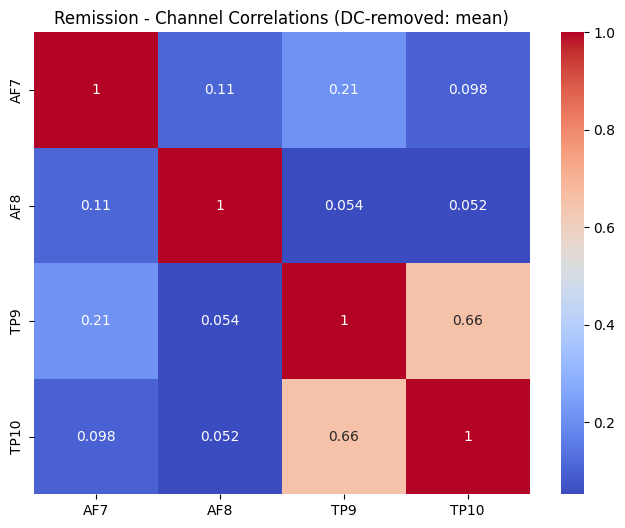

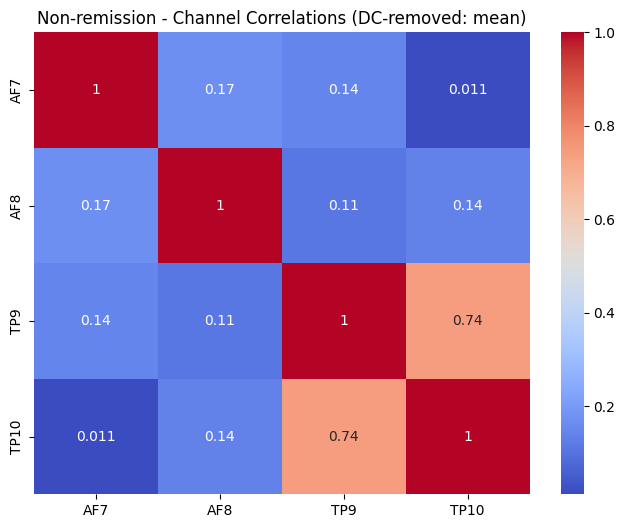

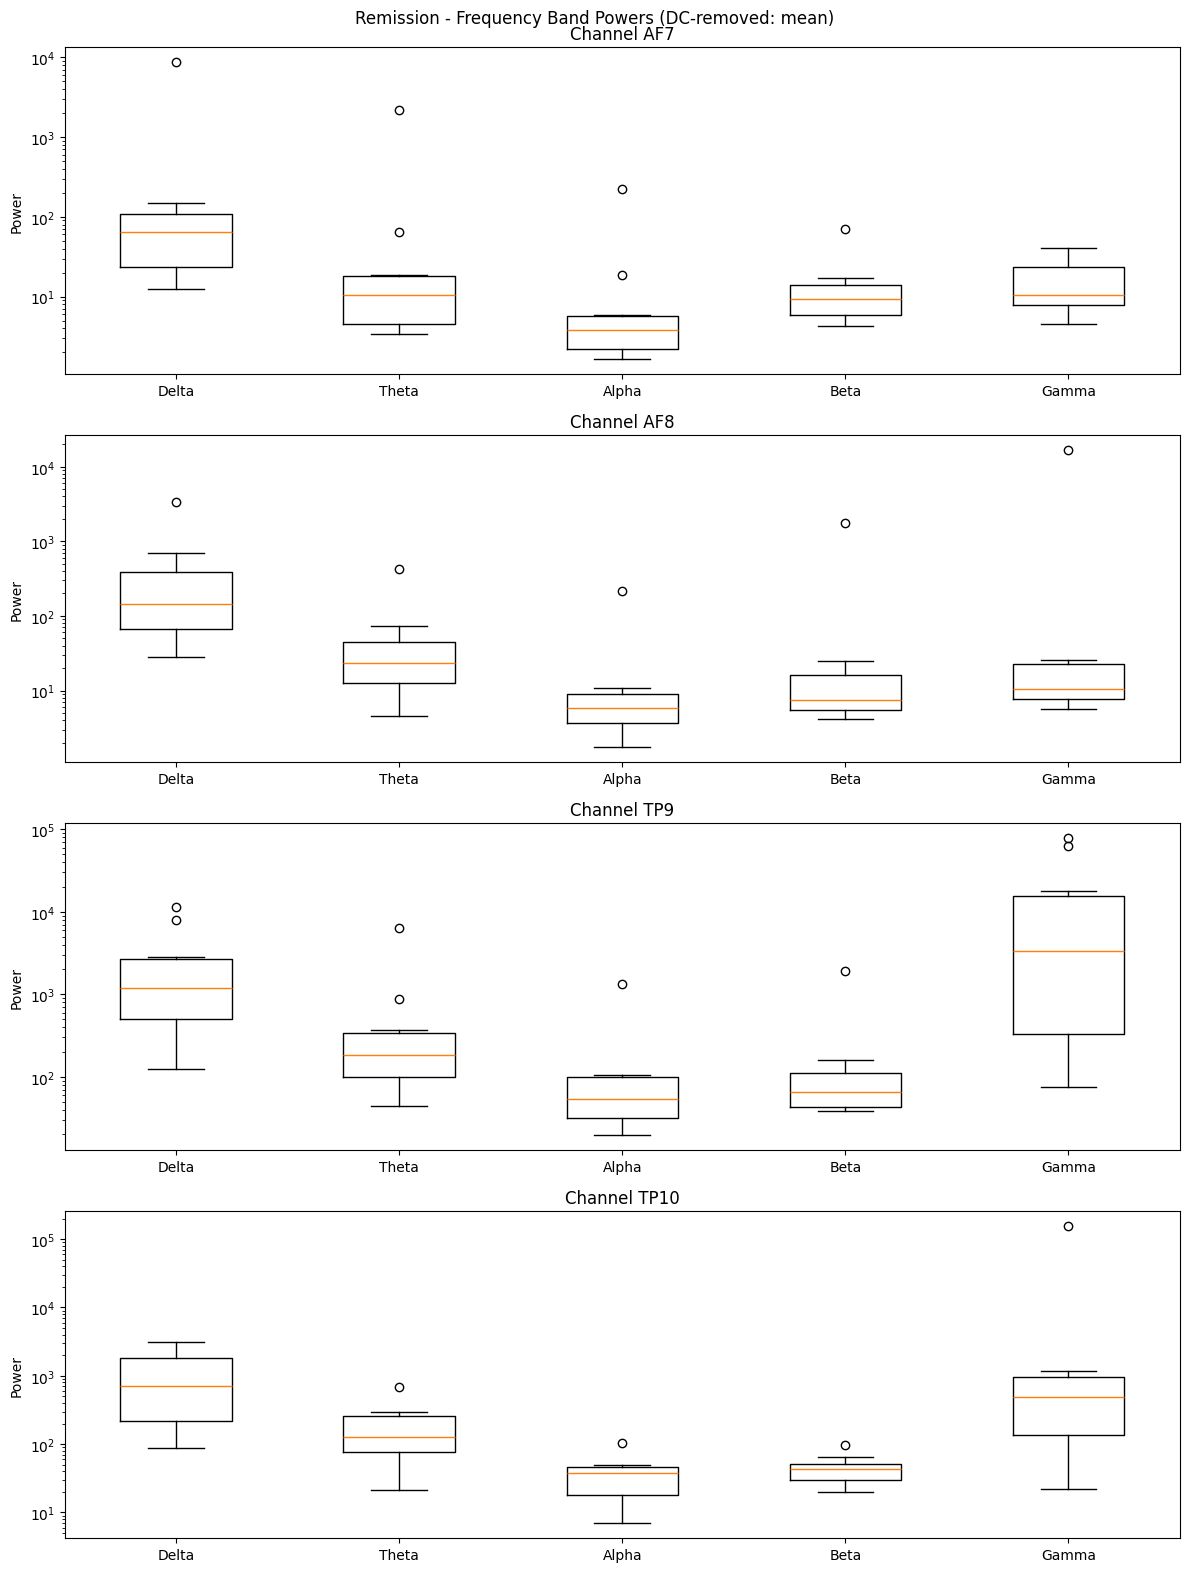

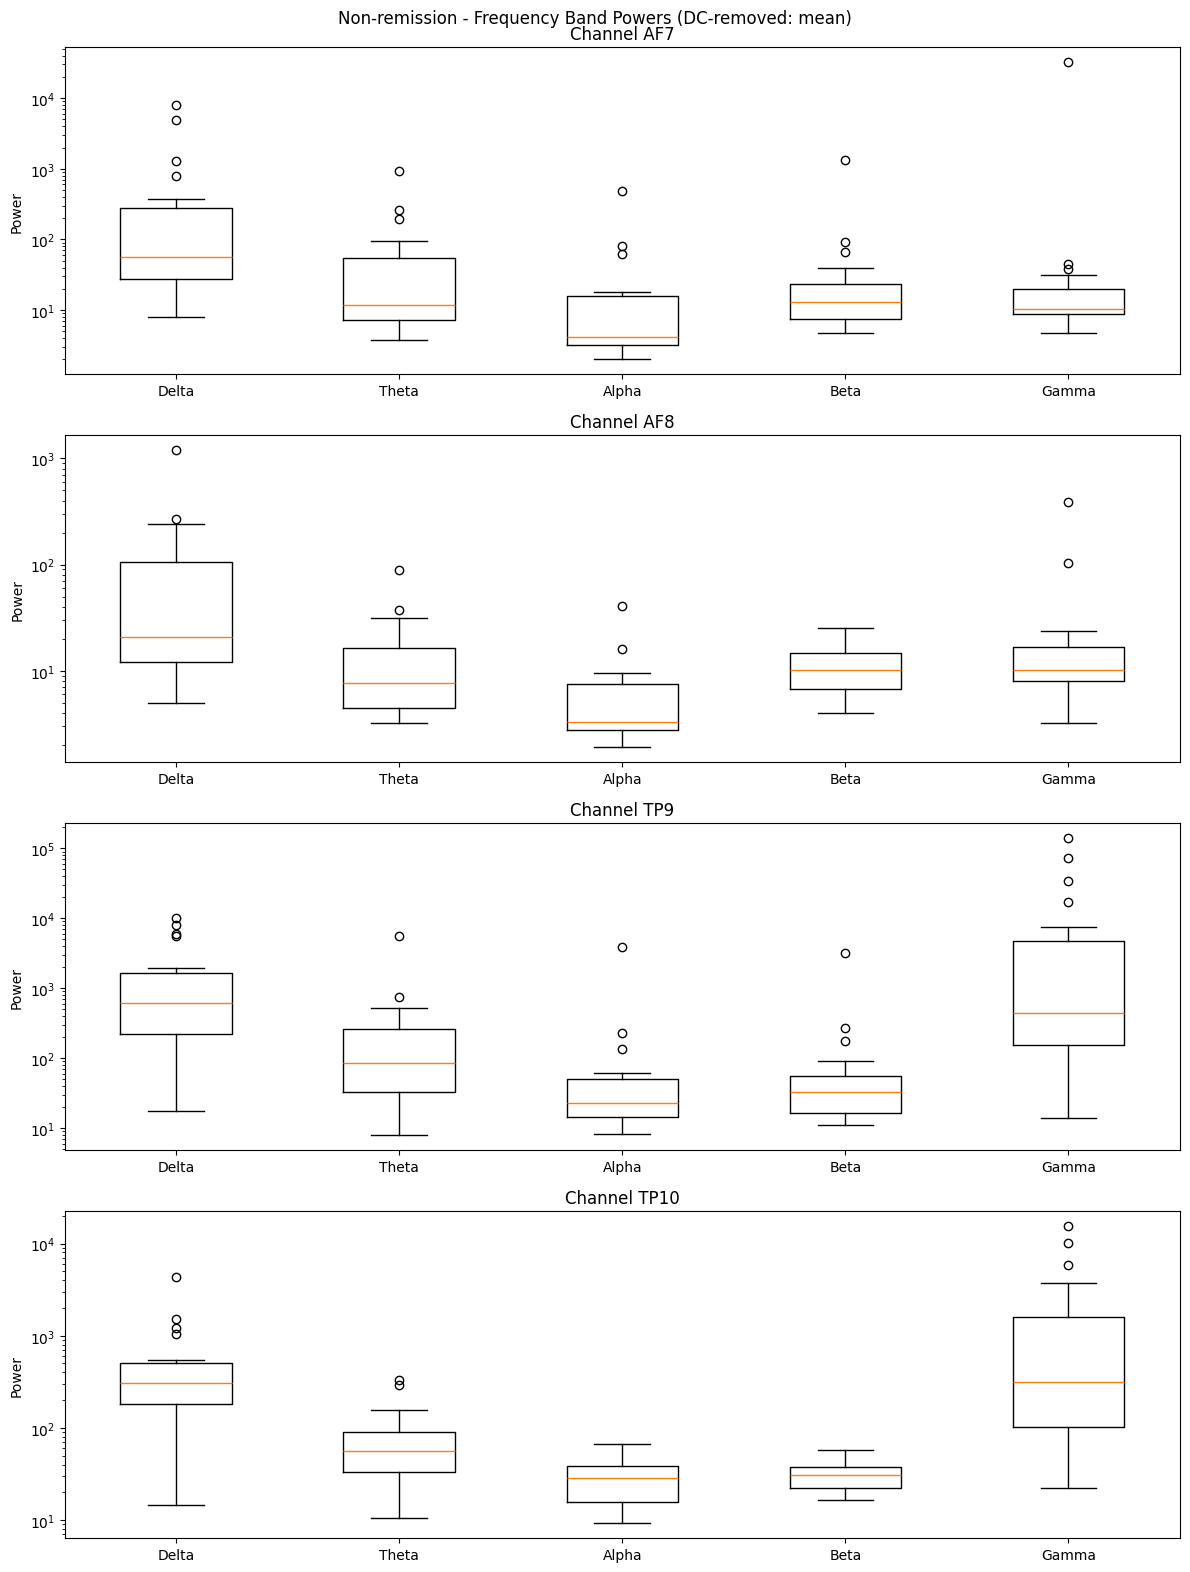

In [ ]:
# === DC-OFFSET REMOVAL COMPARISON ===
# Apply per-channel DC removal (mean or median) and regenerate the same plots
# so you can visually compare against the original ones above.

DC_METHOD = 'mean'  # 'mean' or 'median'


def remove_dc_from_signal(signal_2d: np.ndarray, method: str = 'mean') -> np.ndarray:
    """Remove DC per channel for a 2D signal [samples, channels].
    Additionally, replace exact zeros with the mean of non-zero values per channel before centering.
    """
    if signal_2d is None or signal_2d.size == 0:
        return signal_2d
    sig = np.asarray(signal_2d, dtype=float)
    # Replace zeros with the mean of non-zero values per channel (ignore NaNs)
    zeros_mask = (sig == 0) & ~np.isnan(sig)
    nonzero_mask = (sig != 0) & ~np.isnan(sig)
    nonzero_sum = np.nansum(np.where(nonzero_mask, sig, np.nan), axis=0)
    nonzero_count = np.sum(nonzero_mask, axis=0)
    means = np.divide(nonzero_sum, nonzero_count, out=np.zeros_like(nonzero_sum), where=nonzero_count > 0)
    filled = sig.copy()
    # Broadcast replacement means to zero positions
    if zeros_mask.any():
        filled[zeros_mask] = np.take(means, np.where(zeros_mask)[1])
    # Compute center on filled data
    if method == 'median':
        center = np.nanmedian(filled, axis=0, keepdims=True)
    else:
        center = np.nanmean(filled, axis=0, keepdims=True)
    return filled - center


def plot_signal_characteristics_dc(data, group_name):
    """Same as plot_signal_characteristics but with DC removed."""
    signal_data = data[0, 0][0, 0]
    signal_dc = remove_dc_from_signal(signal_data, method=DC_METHOD)
    channels = ['AF7', 'AF8', 'TP9', 'TP10']

    # Time-domain plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{group_name} - Signal Characteristics (DC-removed: {DC_METHOD})')
    for idx, (ax, channel) in enumerate(zip(axes.flat, channels)):
        ax.plot(signal_dc[:, idx])
        ax.set_title(f'Channel {channel}')
        ax.set_xlabel('Sample')
        ax.set_ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

    # Frequency-domain plots (PSD)
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{group_name} - Frequency Analysis (DC-removed: {DC_METHOD})')
    for idx, (ax, channel) in enumerate(zip(axes.flat, channels)):
        f, Pxx = signal.welch(signal_dc[:, idx], fs=config['window_slicer']['sampling_rate'])
        ax.semilogy(f, Pxx)
        ax.set_title(f'Channel {channel} - PSD')
        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('Power Spectral Density')
        ax.grid(True)
    plt.tight_layout()
    plt.show()


def analyze_channel_correlations_dc(data, group_name):
    """Same as analyze_channel_correlations but with DC removed."""
    channels = ['AF7', 'AF8', 'TP9', 'TP10']
    correlations = []
    for i in range(data.shape[0]):
        signal_data = data[i, 0][0, 0]
        sig_dc = remove_dc_from_signal(signal_data, method=DC_METHOD)
        corr_matrix = np.corrcoef(sig_dc.T)
        correlations.append(corr_matrix)
    avg_correlation = np.mean(correlations, axis=0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(avg_correlation, annot=True, cmap='coolwarm',
                xticklabels=channels, yticklabels=channels)
    plt.title(f'{group_name} - Channel Correlations (DC-removed: {DC_METHOD})')
    plt.show()


def analyze_frequency_bands_dc(data, group_name):
    """Same as analyze_frequency_bands but with DC removed."""
    bands = {
        'Delta': (0.5, 4),
        'Theta': (4, 8),
        'Alpha': (8, 12),
        'Beta': (12, 30),
        'Gamma': (30, 60)
    }
    channels = ['AF7', 'AF8', 'TP9', 'TP10']
    band_powers = {band: {ch: [] for ch in channels} for band in bands}
    fs = config['window_slicer']['sampling_rate']
    for i in range(data.shape[0]):
        signal_data = data[i, 0][0, 0]
        sig_dc = remove_dc_from_signal(signal_data, method=DC_METHOD)
        for ch_idx, channel in enumerate(channels):
            for band_name, band_range in bands.items():
                power = calculate_band_power(sig_dc[:, ch_idx], fs, band_range)
                band_powers[band_name][channel].append(power)
    fig, axes = plt.subplots(len(channels), 1, figsize=(12, 4 * len(channels)))
    fig.suptitle(f'{group_name} - Frequency Band Powers (DC-removed: {DC_METHOD})')
    for idx, (ax, channel) in enumerate(zip(axes, channels)):
        data_to_plot = [band_powers[band][channel] for band in bands]
        ax.boxplot(data_to_plot, tick_labels=list(bands.keys()))
        ax.set_title(f'Channel {channel}')
        ax.set_ylabel('Power')
        ax.set_yscale('log')
    plt.tight_layout()
    plt.show()

print(f"Applying DC removal with method: {DC_METHOD}")

# Regenerate comparable plots with DC-removed signals for both groups
plot_signal_characteristics_dc(mat_data['EEG_windows_Remission'], 'Remission')
plot_signal_characteristics_dc(mat_data['EEG_windows_Non_remission'], 'Non-remission')

analyze_channel_correlations_dc(mat_data['EEG_windows_Remission'], 'Remission')
analyze_channel_correlations_dc(mat_data['EEG_windows_Non_remission'], 'Non-remission')

analyze_frequency_bands_dc(mat_data['EEG_windows_Remission'], 'Remission')
analyze_frequency_bands_dc(mat_data['EEG_windows_Non_remission'], 'Non-remission')

